Install Libraries

In [242]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error,mean_squared_log_error
from sklearn.feature_selection import RFECV
import pickle


Load Dataset

In [243]:
generalStats_pos = pd.read_csv('E:/Inzynierka/generalStats_pos - generalStats_pos.csv')

Data cleaning

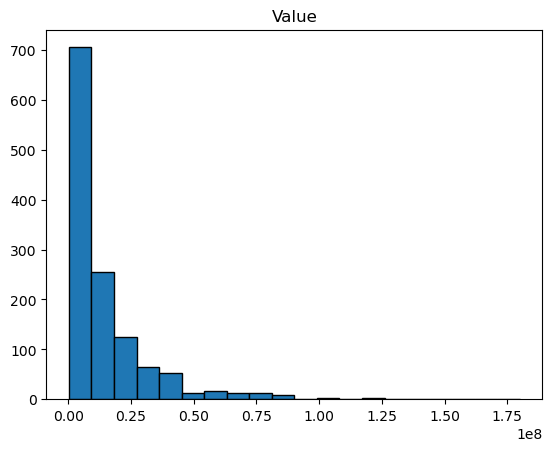

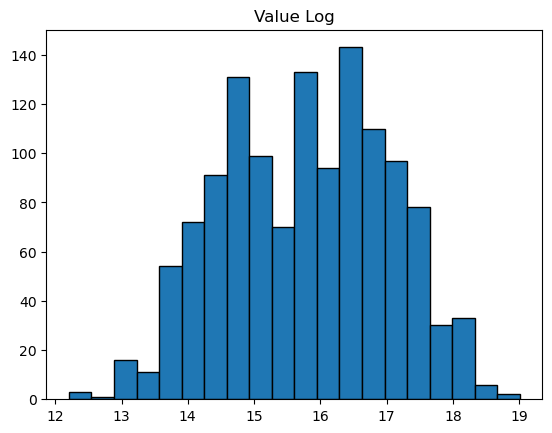

In [244]:
generalStats_pos['value_log'] = generalStats_pos['value'].apply(lambda x: math.log(x))
generalStats_pos = generalStats_pos.dropna()
sorted_data = np.sort(generalStats_pos['value'])
plt.hist(sorted_data, edgecolor='black', bins=20)
plt.title('Value')
plt.show()

sorted_data = np.sort(generalStats_pos['value_log'])
plt.hist(sorted_data, edgecolor='black', bins=20)
plt.title('Value Log')
plt.show()

In [245]:
def calculate_revised_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    msle = mean_squared_log_error(y_true, y_pred)
    median_ae = median_absolute_error(y_true, y_pred)

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R^2": r2,
        "MAPE": mape,
        "MSLE": msle,
        "Median AE": median_ae
    }

In [246]:
X = generalStats_pos.iloc[:, 3:-2]
y = generalStats_pos.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [247]:
model = DecisionTreeRegressor()
model.fit(X_train,y_train)
score = model.score(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


<class 'pandas.core.series.Series'>
0       0.000000
1       0.916291
2       0.000000
3       0.000000
4       0.000000
          ...   
1310    0.000000
1311   -0.980829
1314   -2.995732
1315    0.000000
1316    0.000000
Name: diff_log, Length: 1274, dtype: float64
<class 'pandas.core.series.Series'>
0      -2.384186e-07
1       9.000000e+07
2       1.788139e-07
3       1.788139e-07
4       1.192093e-07
            ...     
1310   -1.746230e-10
1311   -5.000000e+05
1314   -3.800000e+06
1315   -5.820766e-11
1316   -5.820766e-11
Name: diff, Length: 1274, dtype: float64
                          Player      value  estimated_value        diff  \
1                Vinicius Júnior  150000000       60000000.0  90000000.0   
5                          Pedri  100000000       30000000.0  70000000.0   
34                  Éder Militão   70000000        2500000.0  67500000.0   
382              Anthony Martial   15000000       75000000.0 -60000000.0   
49               Ousmane Dembélé   60000000 

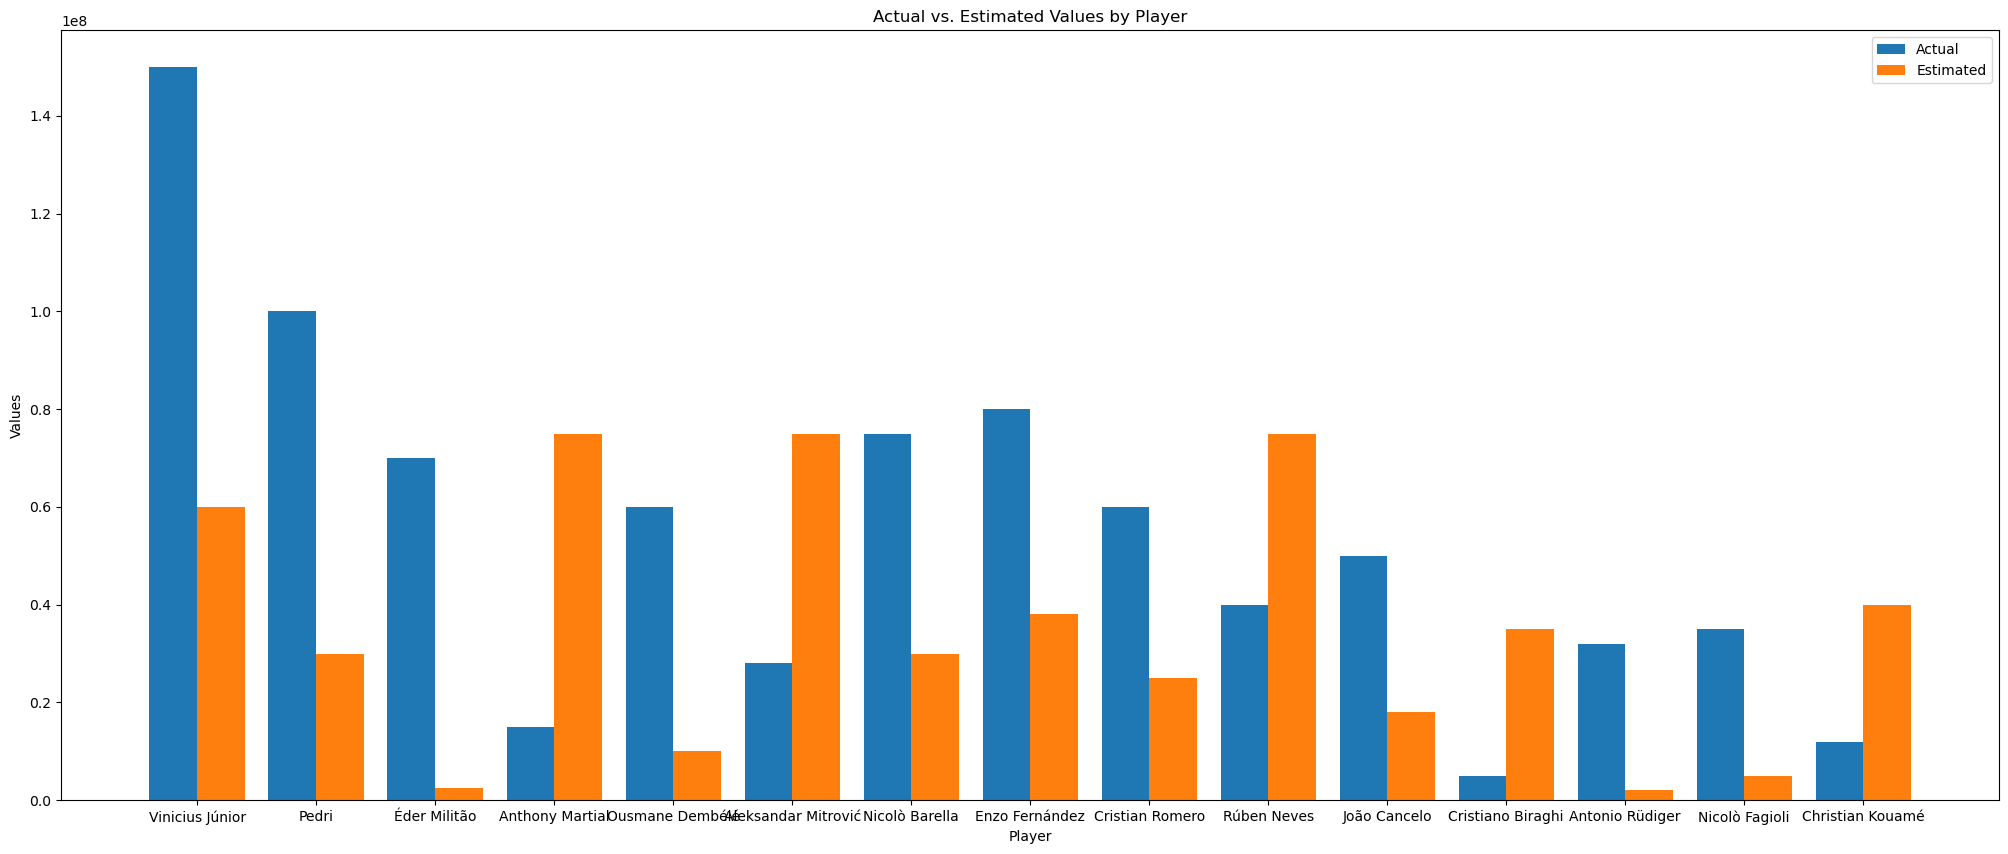

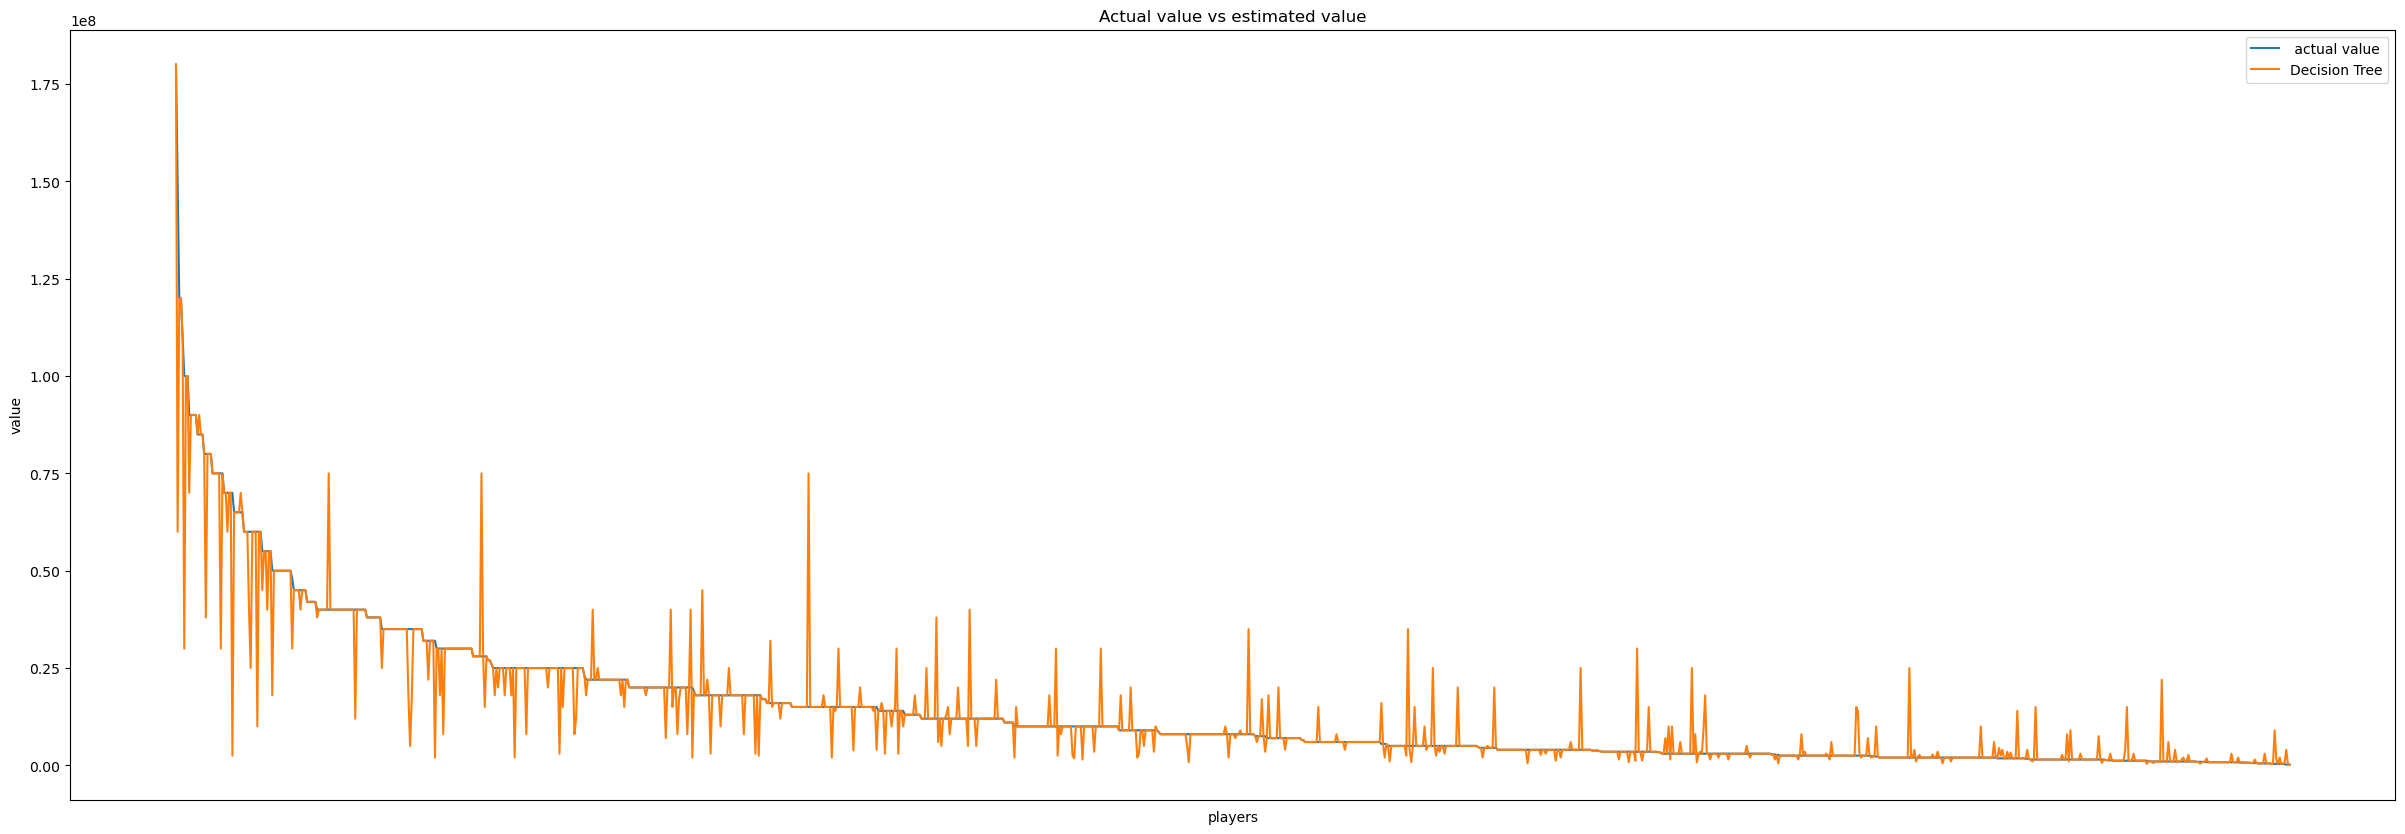

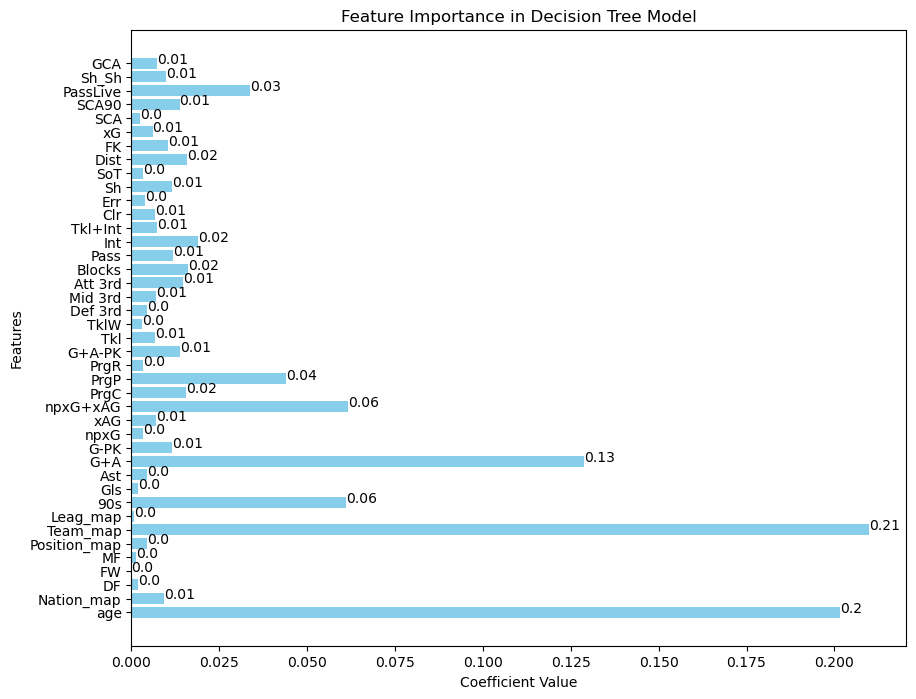

In [248]:
generalStats_pos_local = generalStats_pos.copy()
estimated_value_log = []
for i in range(0,len(generalStats_pos)):
    player_data = generalStats_pos.iloc[i,:].to_frame().transpose()
    player_data = (player_data.iloc[:, 3:-2])
    estimated_value_log.append(float(model.predict(player_data)))



estimated_value = []
generalStats_pos_local['estimated_value_log'] = estimated_value_log
generalStats_pos_local['estimated_value_log'] = generalStats_pos_local['estimated_value_log'].astype(float)
print(type(generalStats_pos_local['estimated_value_log']))
generalStats_pos_local['diff_log'] = generalStats_pos_local['value_log'] - generalStats_pos_local['estimated_value_log']
print(generalStats_pos_local['diff_log'])

for value in generalStats_pos_local['estimated_value_log']:
    estimated_value.append(math.exp(value))
generalStats_pos_local['estimated_value'] = estimated_value
generalStats_pos_local['value'] = generalStats_pos_local['value'].astype(int)
generalStats_pos_local['diff'] = generalStats_pos_local['value'] - generalStats_pos_local['estimated_value']
print(type(generalStats_pos_local['value']))
print(generalStats_pos_local['diff'])

generalStats_pos_local['absolute_diff'] = abs(generalStats_pos_local['diff'])

bestvalued_50 = generalStats_pos_local[['Player','value','estimated_value','diff','absolute_diff']].nlargest(n=50,columns = 'absolute_diff')
print(bestvalued_50)
actual_values = bestvalued_50.head(15)['value']
estimated_values = bestvalued_50.head(15)['estimated_value']
labels = bestvalued_50.head(15)['Player']

x = range(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
bar_width = 0.4 
actual_bars = plt.bar(x, actual_values, width=bar_width, label='Actual', align='center')
estimated_bars = plt.bar([i + bar_width for i in x], estimated_values, width=bar_width, label='Estimated', align='center')

plt.xlabel('Player')
plt.ylabel('Values')
plt.title('Actual vs. Estimated Values by Player')
plt.xticks([i + bar_width/2 for i in x], labels) 
print('Mean difference: ', np.mean(generalStats_pos_local['absolute_diff']))
plt.legend()

plt.show()
plt.figure(figsize=(30, 10))  
plt.xlabel('players')
plt.ylabel('value')
plt.title('Actual value vs estimated value')
plt.xticks([])
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['value'], label=' actual value')
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['estimated_value'], label='Decision Tree')


plt.legend()
plt.show()
coefficients = model.feature_importances_

# Assuming feature names are like 'feature1', 'feature2', etc.
feature_names = generalStats_pos.iloc[:, 3:-2].columns.tolist()

# Step 4: Plotting the feature importance

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, coefficients, color='skyblue')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Feature Importance in Decision Tree Model')

# Adding the coefficient values on the bars
for index, value in enumerate(coefficients):
    ax.text(value, index, str(round(value, 2)))

plt.show()

In [249]:
metrics = calculate_revised_metrics(y_test, y_test_pred)
print(metrics)

{'MAE': 0.8711775361236748, 'MSE': 1.216324472304929, 'RMSE': 1.1028710134485034, 'R^2': 0.23040775569821859, 'MAPE': 5.6572796399318, 'MSLE': 0.004536480521109494, 'Median AE': 0.6931471805599472}


RFE on Decision Tree

In [250]:
%%capture


estimator = DecisionTreeRegressor()
selector = RFECV(estimator, cv=5)
selector = selector.fit(X_train, y_train)

print("Suggested number of features: %d" % selector.n_features_)
print("Selected features: %s" % selector.support_)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)



Which features performs the best

In [251]:
selected_fetures = []
keys = generalStats_pos.iloc[:, 3:-2].keys()
for i in range(0,len(selector.support_)-1):
    if selector.support_[i] == True:
        selected_fetures.append(keys[i])
print(selected_fetures)
print(X_train_selected)

['age', 'Team_map', 'G+A', 'PrgP']
[[ 30.  44.   1.  10.]
 [ 24.  20.  22. 266.]
 [ 31.   2.   3.  75.]
 ...
 [ 35.  51.   2.  80.]
 [ 29.  56.   5. 184.]
 [ 30.   4.   1.  19.]]


Fit the model 

In [252]:
model = DecisionTreeRegressor()
model.fit(X_train_selected,y_train)
score = model.score(X_train_selected,y_train)
y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)
print('Score: ', score)

Score:  0.9996401418852852


<class 'pandas.core.series.Series'>
0       0.000000
1       0.405465
2       0.000000
3       0.000000
4       0.000000
          ...   
1310    0.000000
1311   -0.980829
1314   -2.014903
1315    0.000000
1316    0.000000
Name: diff_log, Length: 1274, dtype: float64
<class 'pandas.core.series.Series'>
0      -2.384186e-07
1       5.000000e+07
2       1.788139e-07
3       1.788139e-07
4       1.192093e-07
            ...     
1310   -1.746230e-10
1311   -5.000000e+05
1314   -1.300000e+06
1315   -5.820766e-11
1316   -5.820766e-11
Name: diff, Length: 1274, dtype: float64
                              Player      value  estimated_value        diff  \
241                     Brais Méndez   25000000      100000000.0 -75000000.0   
304   Domingos André Ribeiro Almeida   20000000       85000000.0 -65000000.0   
14                  Lautaro Martínez   85000000       25000000.0  60000000.0   
34                      Éder Militão   70000000       14000000.0  56000000.0   
49                   Ous

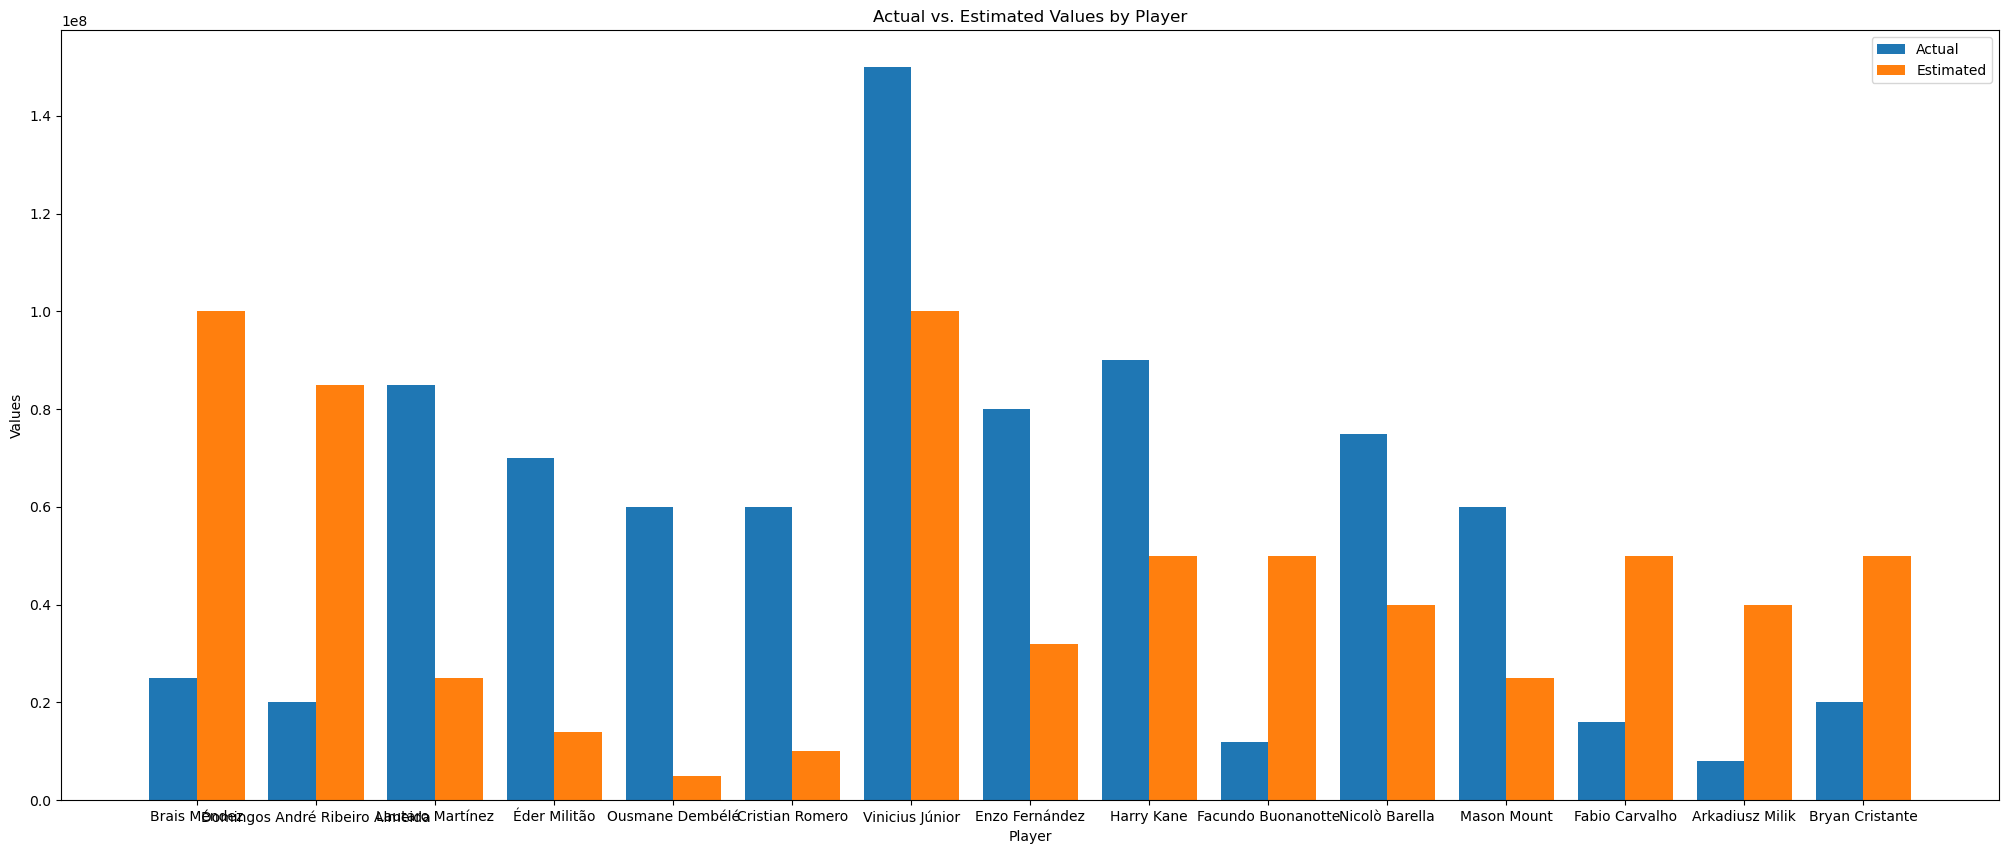

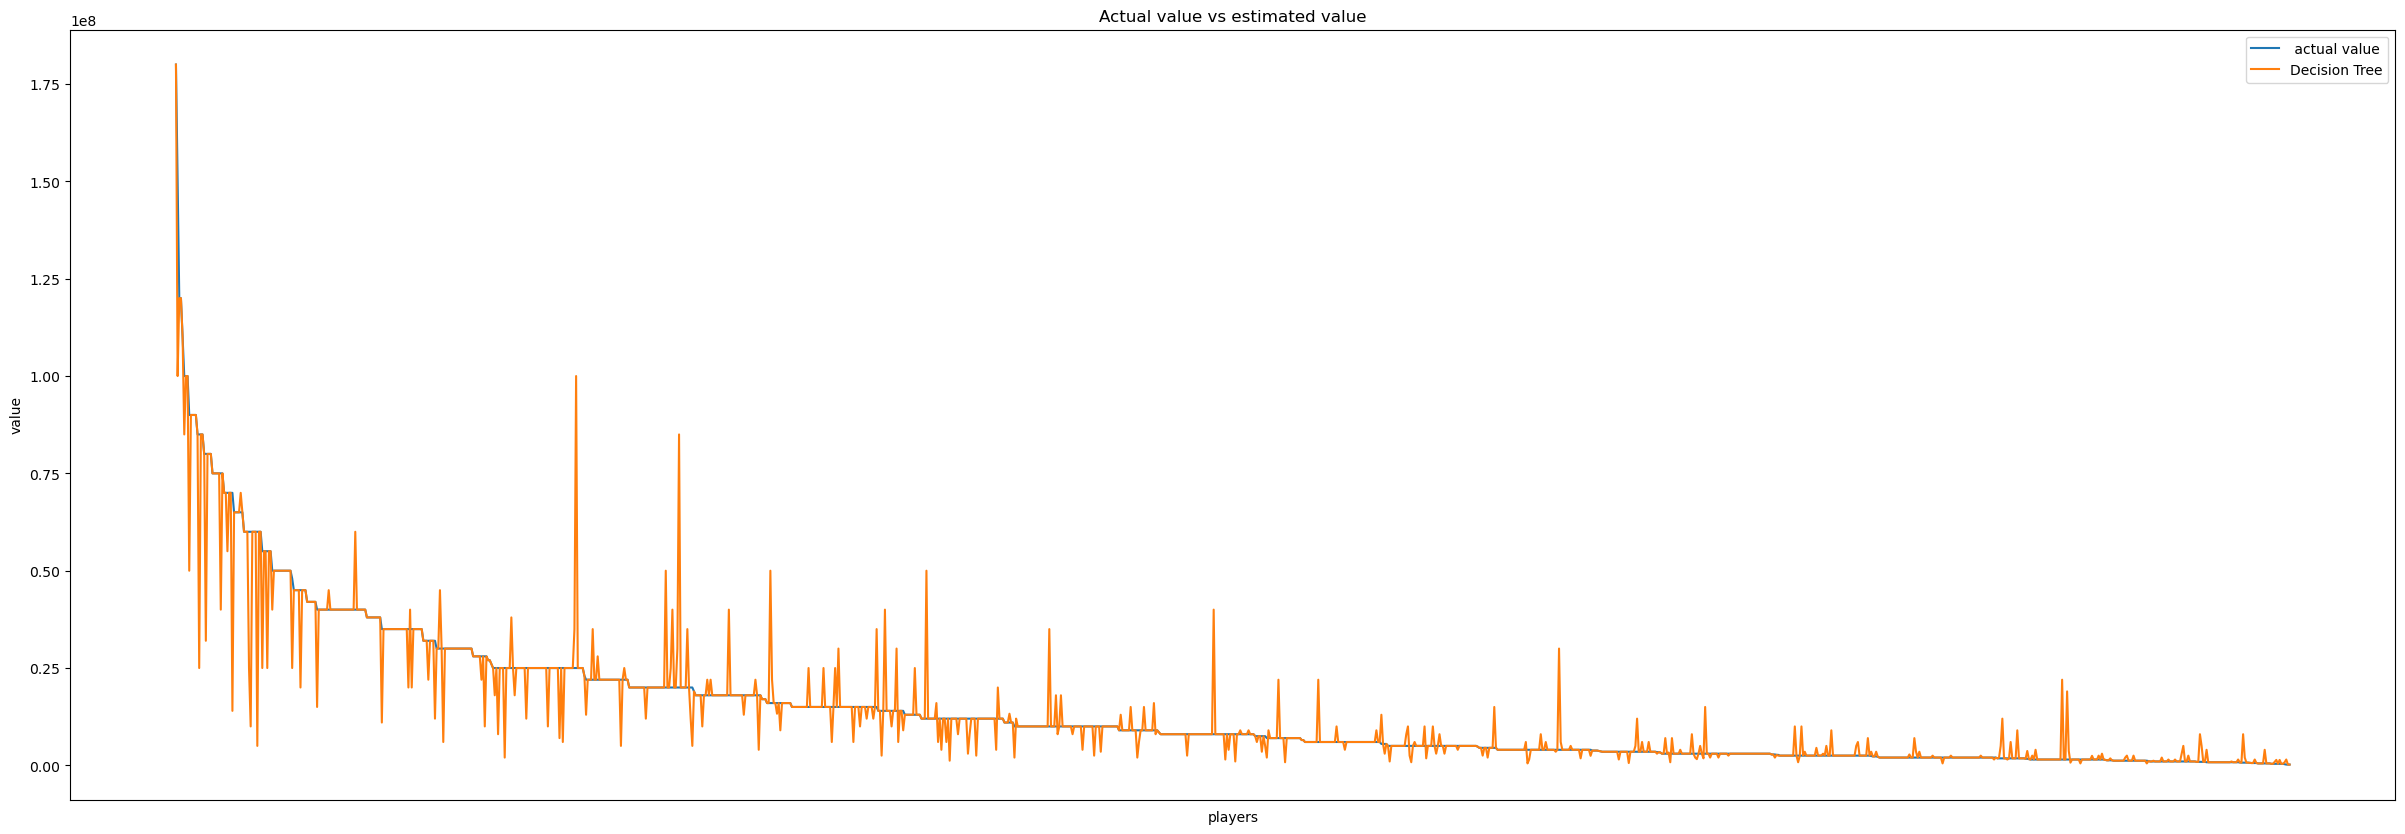

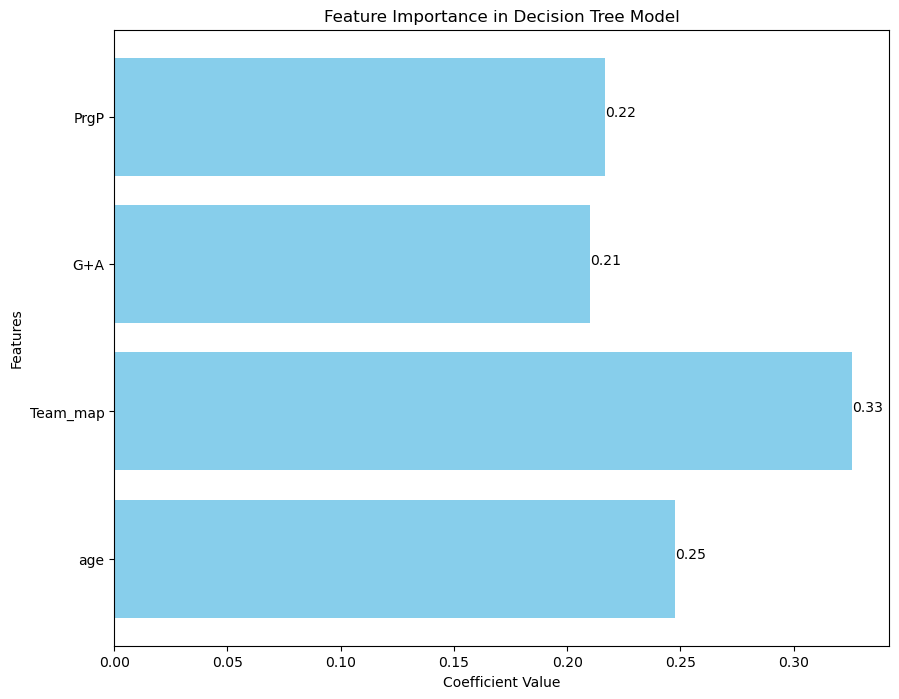

In [253]:
generalStats_pos_local = generalStats_pos.copy()
estimated_value_log = []
for i in range(0,len(generalStats_pos_local)):
    player_data = generalStats_pos_local.iloc[i,:].to_frame().transpose()
    player_data = selector.transform(player_data.iloc[:, 3:-2])
    estimated_value_log.append(float(model.predict(player_data)))



estimated_value = []
generalStats_pos_local['estimated_value_log'] = estimated_value_log
generalStats_pos_local['estimated_value_log'] = generalStats_pos_local['estimated_value_log'].astype(float)
print(type(generalStats_pos_local['estimated_value_log']))
generalStats_pos_local['diff_log'] = generalStats_pos_local['value_log'] - generalStats_pos_local['estimated_value_log']
print(generalStats_pos_local['diff_log'])

for value in generalStats_pos_local['estimated_value_log']:
    estimated_value.append(math.exp(value))
generalStats_pos_local['estimated_value'] = estimated_value
generalStats_pos_local['value'] = generalStats_pos_local['value'].astype(int)
generalStats_pos_local['diff'] = generalStats_pos_local['value'] - generalStats_pos_local['estimated_value']
print(type(generalStats_pos_local['value']))
print(generalStats_pos_local['diff'])

generalStats_pos_local['absolute_diff'] = abs(generalStats_pos_local['diff'])

bestvalued_50 = generalStats_pos_local[['Player','value','estimated_value','diff','absolute_diff']].nlargest(n=50,columns = 'absolute_diff')
print(bestvalued_50)
actual_values = bestvalued_50.head(15)['value']
estimated_values = bestvalued_50.head(15)['estimated_value']
labels = bestvalued_50.head(15)['Player']

x = range(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
bar_width = 0.4 
actual_bars = plt.bar(x, actual_values, width=bar_width, label='Actual', align='center')
estimated_bars = plt.bar([i + bar_width for i in x], estimated_values, width=bar_width, label='Estimated', align='center')

plt.xlabel('Player')
plt.ylabel('Values')
plt.title('Actual vs. Estimated Values by Player')
plt.xticks([i + bar_width/2 for i in x], labels) 
print('Mean difference: ', np.mean(generalStats_pos_local['absolute_diff']))
plt.legend()

plt.show()
plt.figure(figsize=(30, 10))  
plt.xlabel('players')
plt.ylabel('value')
plt.title('Actual value vs estimated value')
plt.xticks([])
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['value'], label=' actual value')
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['estimated_value'], label='Decision Tree')


plt.legend()
plt.show()
coefficients = model.feature_importances_

# Assuming feature names are like 'feature1', 'feature2', etc.
feature_names = selected_fetures

# Step 4: Plotting the feature importance

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, coefficients, color='skyblue')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Feature Importance in Decision Tree Model')

# Adding the coefficient values on the bars
for index, value in enumerate(coefficients):
    ax.text(value, index, str(round(value, 2)))

plt.show()

In [254]:
metrics = calculate_revised_metrics(y_test, y_test_pred)
print(metrics)

{'MAE': 0.7763016879268144, 'MSE': 0.9304958482962115, 'RMSE': 0.9646221272064058, 'R^2': 0.4112571073681016, 'MAPE': 5.019489455928521, 'MSLE': 0.0034768689002845263, 'Median AE': 0.6286086594223743}


In [255]:
# %%capture
# param_grid = {'max_depth': [None, 2,4,6,8,10,12],
#          'min_samples_split': [2,3,4,5,6,7,8,9,10],
#          'min_samples_leaf': [1,2]}
# clf = DecisionTreeRegressor()
# gcv = GridSearchCV(estimator=clf,param_grid=param_grid, cv = 5)
# gcv.fit(X_train_selected,y_train)


In [256]:
best_params = {'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 1,}
#best_params = gcv.best_params_
model = DecisionTreeRegressor(**best_params)
model.fit(X_train_selected,y_train)
score = model.score(X_train_selected,y_train)
y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)
print('Score: ', score)

Score:  0.5722853074694454


Perform Hyperparameter tuning by fitting the grid of parameters to the Random Forest and looking for the best combination of features

Evaluate model after hyperparameter tuning

<class 'pandas.core.series.Series'>
0       1.755742
1       1.783578
2       1.350277
3       1.560434
4       1.263266
          ...   
1310   -2.074732
1311   -2.362414
1314   -3.018025
1315   -1.412057
1316   -2.767879
Name: diff_log, Length: 1274, dtype: float64
<class 'pandas.core.series.Series'>
0       1.488998e+08
1       1.247946e+08
2       8.889979e+07
3       9.479461e+07
4       7.889979e+07
            ...     
1310   -2.784964e+06
1311   -2.884964e+06
1314   -3.890172e+06
1315   -6.208781e+05
1316   -2.984964e+06
Name: diff, Length: 1274, dtype: float64
                    Player      value  estimated_value          diff  \
0           Erling Haaland  180000000     3.110021e+07  1.488998e+08   
1          Vinicius Júnior  150000000     2.520539e+07  1.247946e+08   
3           Victor Osimhen  120000000     2.520539e+07  9.479461e+07   
5                    Pedri  100000000     1.083036e+07  8.916964e+07   
2              Bukayo Saka  120000000     3.110021e+07  8.889979

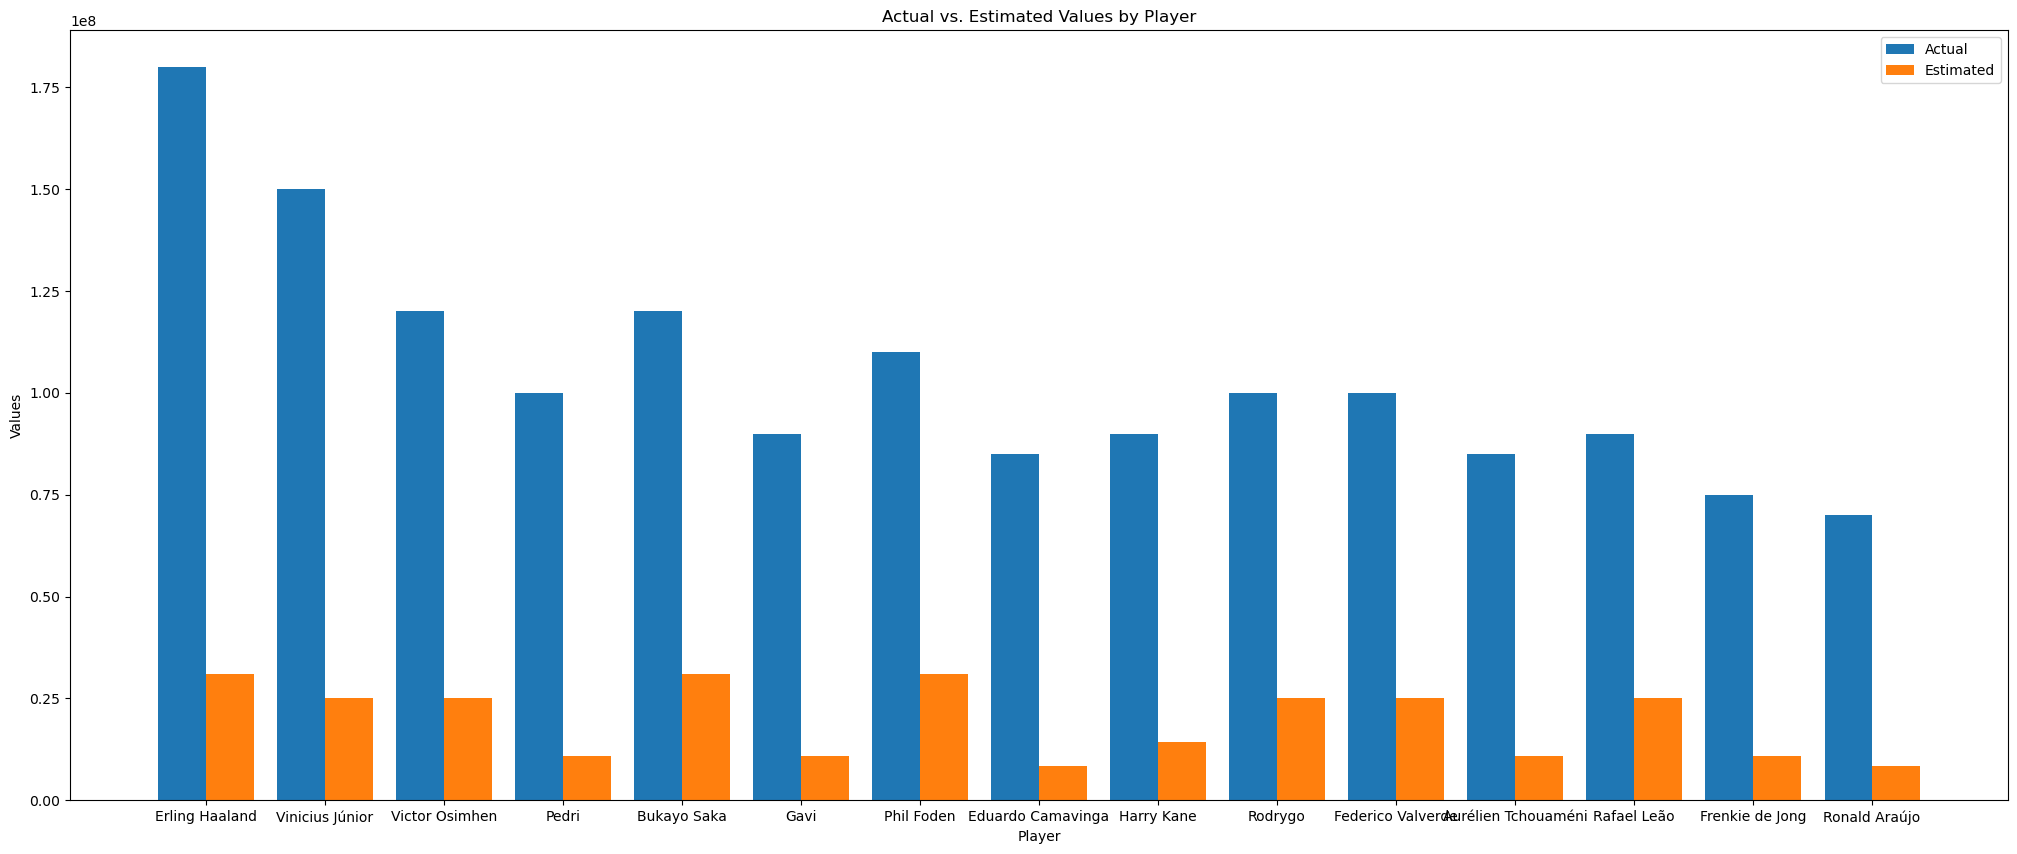

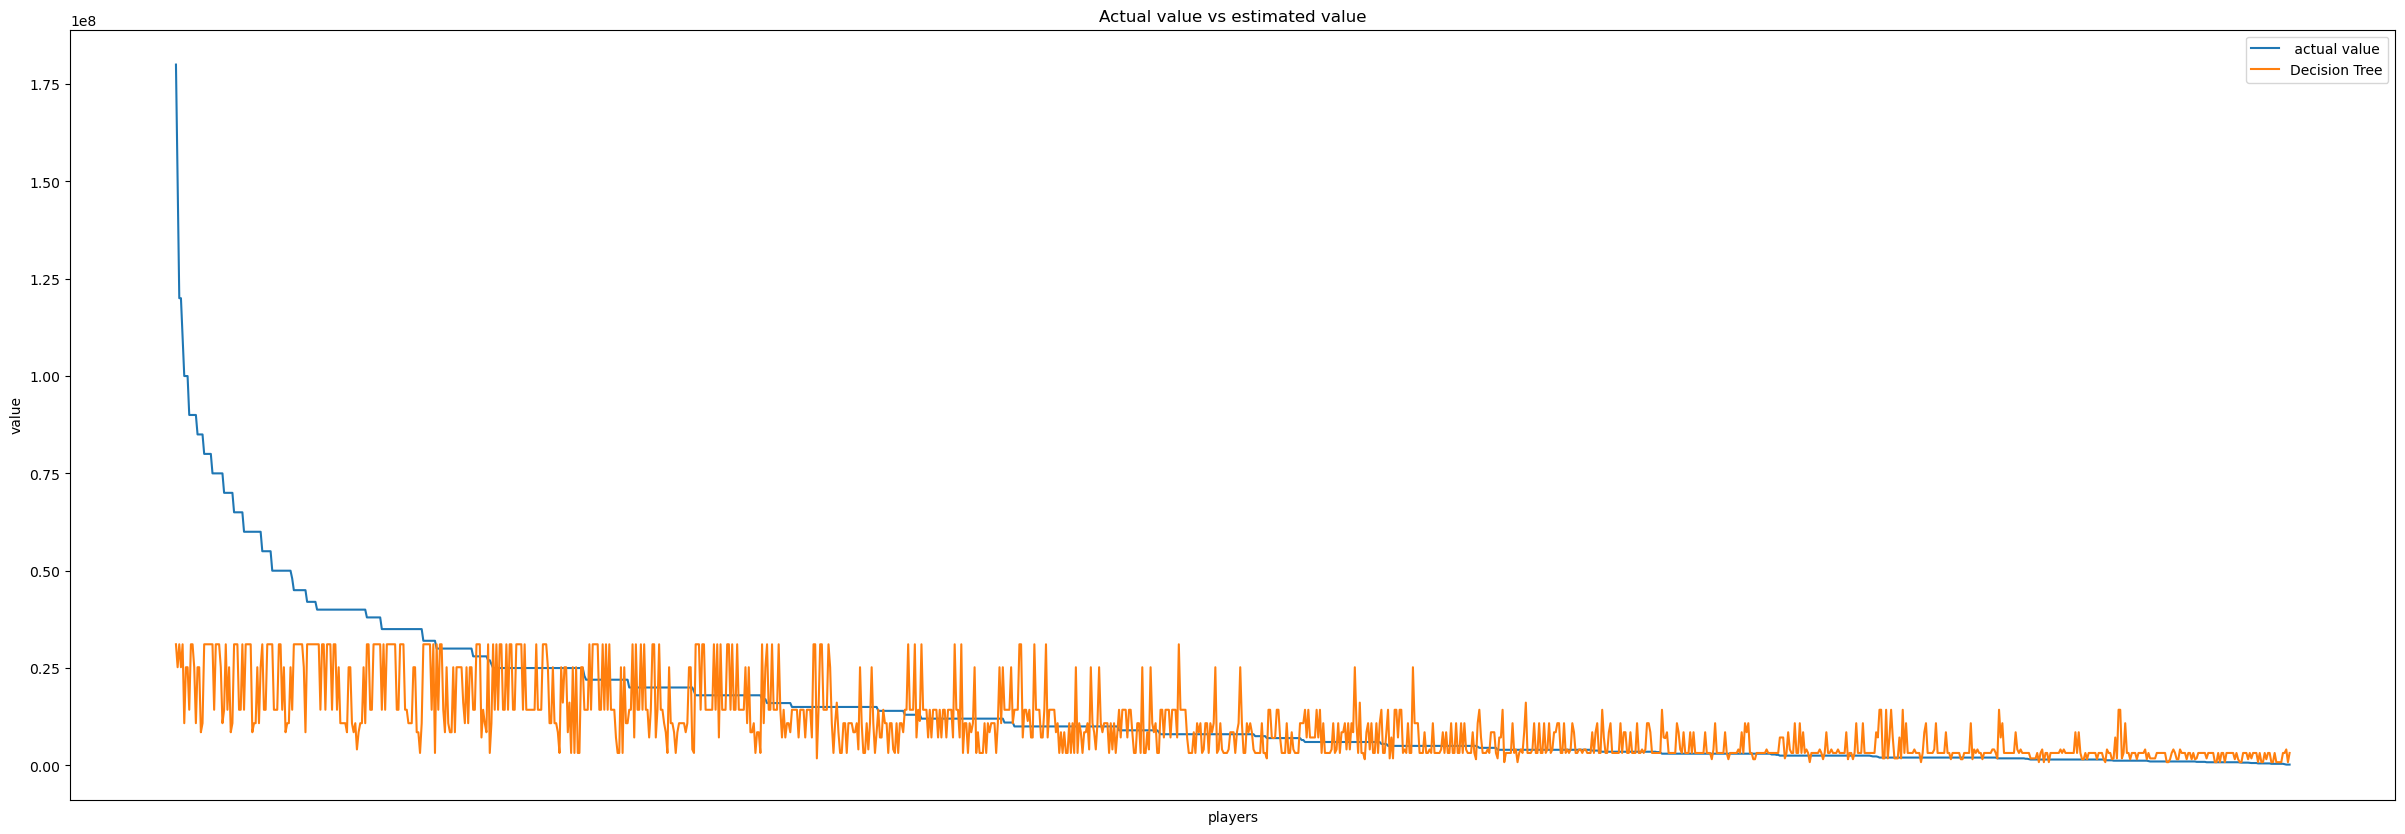

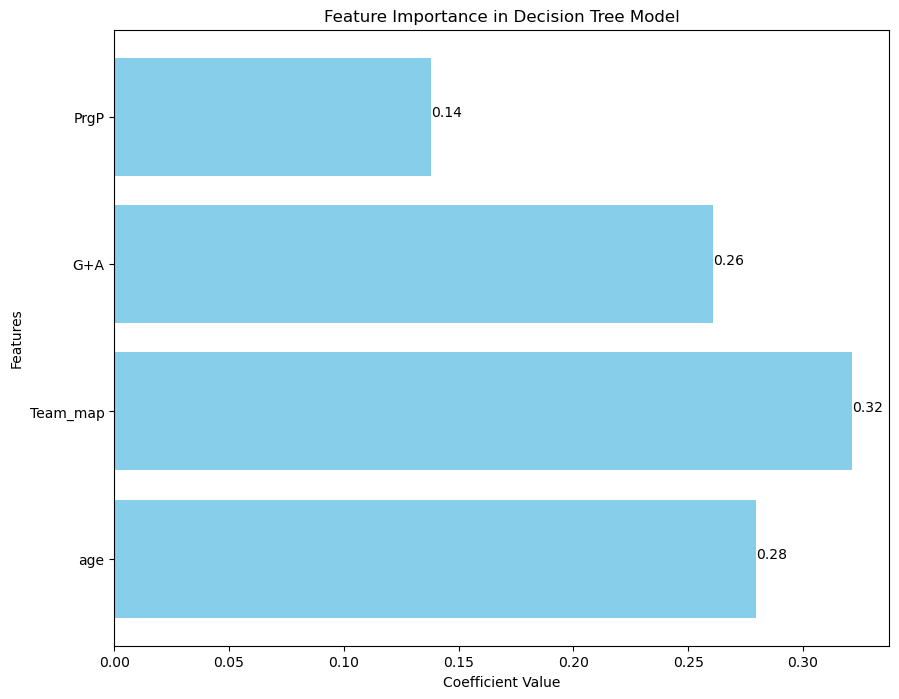

In [257]:
generalStats_pos_local = generalStats_pos.copy()
estimated_value_log = []
for i in range(0,len(generalStats_pos_local)):
    player_data = generalStats_pos_local.iloc[i,:].to_frame().transpose()
    player_data = selector.transform(player_data.iloc[:, 3:-2])
    estimated_value_log.append(float(model.predict(player_data)))



estimated_value = []
generalStats_pos_local['estimated_value_log'] = estimated_value_log
generalStats_pos_local['estimated_value_log'] = generalStats_pos_local['estimated_value_log'].astype(float)
print(type(generalStats_pos_local['estimated_value_log']))
generalStats_pos_local['diff_log'] = generalStats_pos_local['value_log'] - generalStats_pos_local['estimated_value_log']
print(generalStats_pos_local['diff_log'])

for value in generalStats_pos_local['estimated_value_log']:
    estimated_value.append(math.exp(value))
generalStats_pos_local['estimated_value'] = estimated_value
generalStats_pos_local['value'] = generalStats_pos_local['value'].astype(int)
generalStats_pos_local['diff'] = generalStats_pos_local['value'] - generalStats_pos_local['estimated_value']
print(type(generalStats_pos_local['value']))
print(generalStats_pos_local['diff'])

generalStats_pos_local['absolute_diff'] = abs(generalStats_pos_local['diff'])

bestvalued_50 = generalStats_pos_local[['Player','value','estimated_value','diff','absolute_diff']].nlargest(n=50,columns = 'absolute_diff')
print(bestvalued_50)
actual_values = bestvalued_50.head(15)['value']
estimated_values = bestvalued_50.head(15)['estimated_value']
labels = bestvalued_50.head(15)['Player']

x = range(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
bar_width = 0.4 
actual_bars = plt.bar(x, actual_values, width=bar_width, label='Actual', align='center')
estimated_bars = plt.bar([i + bar_width for i in x], estimated_values, width=bar_width, label='Estimated', align='center')

plt.xlabel('Player')
plt.ylabel('Values')
plt.title('Actual vs. Estimated Values by Player')
plt.xticks([i + bar_width/2 for i in x], labels) 
print('Mean difference: ', np.mean(generalStats_pos_local['absolute_diff']))
plt.legend()

plt.show()
plt.figure(figsize=(30, 10))  
plt.xlabel('players')
plt.ylabel('value')
plt.title('Actual value vs estimated value')
plt.xticks([])
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['value'], label=' actual value')
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['estimated_value'], label='Decision Tree')


plt.legend()
plt.show()
coefficients = model.feature_importances_

# Assuming feature names are like 'feature1', 'feature2', etc.
feature_names = selected_fetures

# Step 4: Plotting the feature importance

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, coefficients, color='skyblue')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Feature Importance in Decision Tree Model')

# Adding the coefficient values on the bars
for index, value in enumerate(coefficients):
    ax.text(value, index, str(round(value, 2)))

plt.show()

In [258]:
metrics = calculate_revised_metrics(y_test, y_test_pred)
print(metrics)

{'MAE': 0.6634889317228908, 'MSE': 0.7376418378238732, 'RMSE': 0.8588607790695028, 'R^2': 0.533279605575963, 'MAPE': 4.294077525746076, 'MSLE': 0.002740094463084221, 'Median AE': 0.5468427962021281}


In [266]:
with open('E:/Inzynierka/model/decision_tree_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [267]:
print(best_params)

{'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 1}


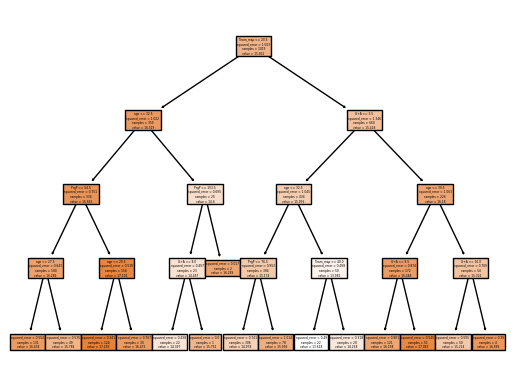

In [268]:

plot_tree(model, 
          filled=True, 
          feature_names=selected_fetures
          )  # Replace 'feature_names' with your actual feature names
plt.show()